In [1]:
from scipy.stats import wasserstein_distance
#import keras
import tensorflow as tf
from keras.layers import Dense, Dropout, Input, BatchNormalization, Concatenate
from keras.models import Model,Sequential
from keras.datasets import mnist
from tqdm import tqdm
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam
from keras import callbacks
from tensorflow import keras

from sklearn.model_selection import train_test_split

import energyflow as ef
from energyflow.archs import DNN
from sklearn.utils import class_weight, shuffle

/home/user/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/user/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/user/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/user/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWa

In [2]:
nFeat = 6
n_gen = 400000

# Load Data for Classification

In [3]:
# load real mc sample
innerdata_train = np.load("../CATHODE/preprocessed_data_6var_3prong/innerdata_train_6var.npy")
X_mc_train = innerdata_train[:,1:nFeat+1]
print("shape of X_mc_train: ", X_mc_train.shape)
innerdata_val = np.load("../CATHODE/preprocessed_data_6var_3prong/innerdata_val_6var.npy")
X_mc_val = innerdata_val[:,1:nFeat+1]
print("shape of X_mc_val: ", X_mc_val.shape)

# load generated bkg sample
gen_SR_train = innerdata_train[innerdata_train[:,nFeat+1]==0]
gen_SR_train = gen_SR_train[:,1:nFeat+1]
print("shape of gen_SR_train", gen_SR_train.shape)
gen_SR_val = innerdata_val[innerdata_val[:,nFeat+1]==0]
gen_SR_val = gen_SR_val[:,1:nFeat+1]
print("shape of gen_SR_val", gen_SR_val.shape)

# load test mc sample
innerdata_test = np.load("../CATHODE/preprocessed_data_6var_3prong/innerdata_test_6var.npy")
innerdata_extrabkg_test = np.load("../CATHODE/preprocessed_data_6var_3prong/innerdata_extrabkg_test_6var.npy")
innerdata_test = np.concatenate((innerdata_test, innerdata_extrabkg_test), axis=0)
X_mc_test = innerdata_test[:,1:nFeat+1]
print("shape of X_mc_test: ", X_mc_test.shape)

shape of X_mc_train:  (60000, 6)
shape of X_mc_val:  (60000, 6)
shape of gen_SR_train (59598, 6)
shape of gen_SR_val (59620, 6)
shape of X_mc_test:  (360000, 6)


In [4]:
X_train_mc_and_gen = np.concatenate((X_mc_train, gen_SR_train), axis=0)
print("shape of training mc and data combination: ", X_train_mc_and_gen.shape)

X_val_mc_and_gen = np.concatenate((X_mc_val, gen_SR_val), axis=0)
print("shape of val mc and data combination: ", X_val_mc_and_gen.shape)

shape of training mc and data combination:  (119598, 6)
shape of val mc and data combination:  (119620, 6)


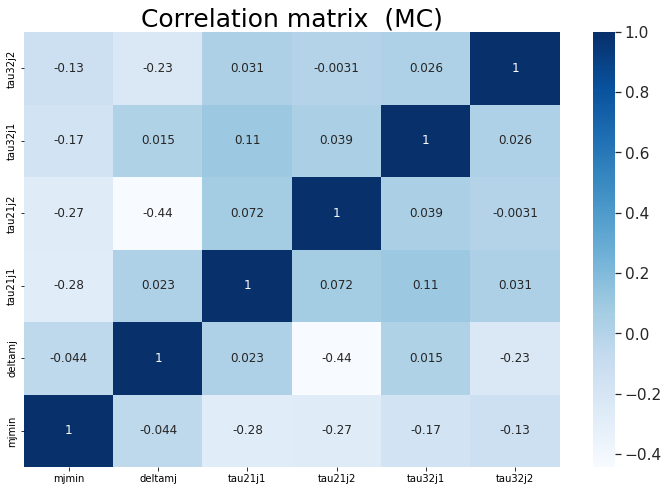

In [5]:
import seaborn as sn
import pandas as pd

obs_arr = ['mjmin', 'deltamj', 'tau21j1', 'tau21j2', 'tau32j1', 'tau32j2']

fig_corr, ax_corr = plt.subplots(figsize=(12,8))

sn.set(font_scale=1.4)
corrMatrix = pd.DataFrame(gen_SR_train, columns=obs_arr).corr()
sn.heatmap(corrMatrix, annot=True, cmap="Blues", annot_kws={"size": 12})
plt.title('Correlation matrix  (MC)', fontsize=25)
ax_corr.set_ylim(0, 6)
plt.show()
# fig_corr.savefig('classifier_ideal_6var_3prong/corr_mc.png')


In [6]:
y_train_mc = np.ones(X_mc_train.shape[0])
print("shape of train_mc label: ", y_train_mc.shape)

y_train_gen = np.zeros(gen_SR_train.shape[0])
print("shape of train_gen label: ", y_train_gen.shape)

y_val_mc = np.ones(X_mc_val.shape[0])
print("shape of val_mc label: ", y_val_mc.shape)

y_val_gen = np.zeros(gen_SR_val.shape[0])
print("shape of val_gen label: ", y_val_gen.shape)

y_mc_test = innerdata_test[:,nFeat+1]
print("shape of mc_test label: ", y_mc_test.shape)


shape of train_mc label:  (60000,)
shape of train_gen label:  (59598,)
shape of val_mc label:  (60000,)
shape of val_gen label:  (59620,)
shape of mc_test label:  (360000,)


In [7]:
y_train_mc_and_gen = np.concatenate((y_train_mc, y_train_gen), axis=0)
print("shape of training mc and data label combination: ", y_train_mc_and_gen.shape)

y_val_mc_and_gen = np.concatenate((y_val_mc, y_val_gen), axis=0)
print("shape of val mc and data label combination: ", y_val_mc_and_gen.shape)

shape of training mc and data label combination:  (119598,)
shape of val mc and data label combination:  (119620,)


In [8]:
shuffle_seed = 42
X_train_mc_and_gen, y_train_mc_and_gen = shuffle(X_train_mc_and_gen, y_train_mc_and_gen, random_state = shuffle_seed)
X_val_mc_and_gen, y_val_mc_and_gen = shuffle(X_val_mc_and_gen, y_val_mc_and_gen, random_state = shuffle_seed)
X_mc_test, y_mc_test = shuffle(X_mc_test, y_mc_test, random_state = shuffle_seed)

In [9]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train_mc_and_gen)
#transform training dataset
X_train_mc_and_gen = scaler.transform(X_train_mc_and_gen)
# transform val dataset
X_val_mc_and_gen = scaler.transform(X_val_mc_and_gen)

In [10]:
# transform test dataset
X_mc_test = scaler.transform(X_mc_test)

In [11]:
optimizer = Adam(lr=1e-3)
model = Sequential()
model.add(Dense(64, input_dim=nFeat, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()
# dense_sizes = (64,64,64)
# optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
# model = DNN(input_dim=nFeat, dense_sizes=dense_sizes, loss="binary_crossentropy", optimizer=optimizer, output_act='sigmoid', summary=True)






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                448       
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 8,833
Trainable params: 8,833
Non-trainable params: 0
_________________________________________________________________


In [12]:
history = tf.keras.callbacks.History()
num_epoch=100
batch_size=128
class_weights = class_weight.compute_class_weight('balanced',np.unique(y_train_mc_and_gen),y_train_mc_and_gen)
class_weights_dict = dict(enumerate(class_weights))

class CustomSaver(callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        self.model.save("classifier_ideal_6var_3prong/model_ideal_6var_epoch{}.h5".format(epoch))

saver = CustomSaver()

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:72: FutureWarning: Pass classes=[0. 1.], y=[0. 1. 0. ... 0. 1. 1.] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


In [13]:
model.fit(X_train_mc_and_gen, y_train_mc_and_gen, 
        epochs=num_epoch,
        batch_size=batch_size,
        class_weight=class_weights_dict,
        validation_data=(X_val_mc_and_gen, y_val_mc_and_gen), 
        shuffle=shuffle,
        verbose=1,callbacks=[history,saver])


Train on 119598 samples, validate on 119620 samples
Epoch 1/100
119598/119598 [==============================] - 5s 40us/step - loss: 0.6938 - acc: 0.4997 - val_loss: 0.6932 - val_acc: 0.5014
Epoch 2/100
119598/119598 [==============================] - 4s 34us/step - loss: 0.6934 - acc: 0.4996 - val_loss: 0.6931 - val_acc: 0.5009
Epoch 3/100
119598/119598 [==============================] - 4s 34us/step - loss: 0.6933 - acc: 0.4988 - val_loss: 0.6931 - val_acc: 0.5015
Epoch 4/100
119598/119598 [==============================] - 4s 34us/step - loss: 0.6932 - acc: 0.4985 - val_loss: 0.6931 - val_acc: 0.5006
Epoch 5/100
119598/119598 [==============================] - 4s 33us/step - loss: 0.6932 - acc: 0.4991 - val_loss: 0.6931 - val_acc: 0.5012
Epoch 6/100
119598/119598 [==============================] - 4s 33us/step - loss: 0.6932 - acc: 0.4980 - val_loss: 0.6931 - val_acc: 0.5007
Epoch 7/100
119598/119598 [==============================] - 4s 33us/step - loss: 0.6932 - acc: 0.4961 - va

In [14]:
class_weights_dict

{0: 1.0033725963958522, 1: 0.99665}

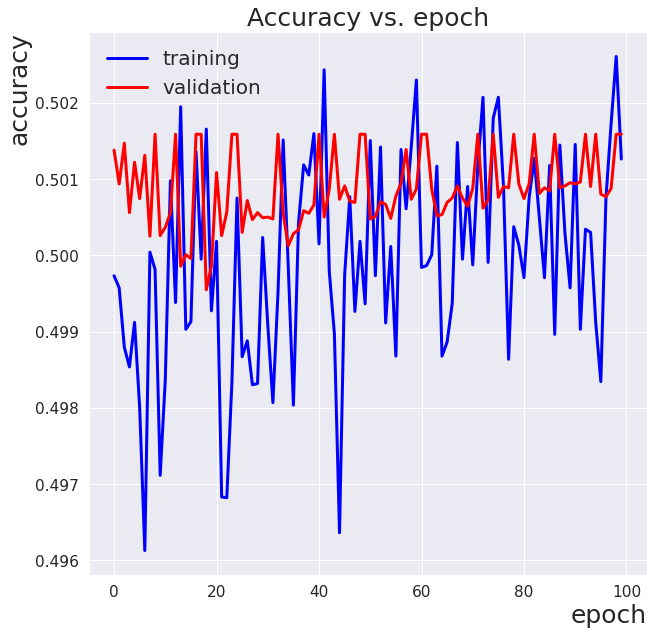

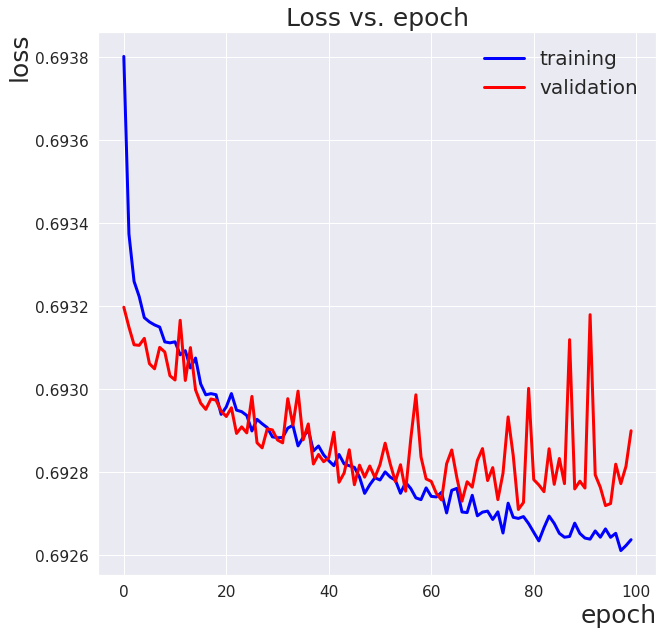

In [15]:
"""
Accuracy of training and validating
"""
fig1, ax1 = plt.subplots(1,1, figsize=(10,10))

plt.plot(np.arange(0,num_epoch), history.history['acc'], label='training',c='blue',linewidth = 3)
plt.plot(np.arange(0,num_epoch), history.history['val_acc'], label='validation',c='red',linewidth = 3)

plt.title("Accuracy vs. epoch", fontsize=25)

ax1.set_ylabel('accuracy', fontsize=25,horizontalalignment='right',y=1)
ax1.set_xlabel('epoch', fontsize=25,horizontalalignment='right',x=1)
plt.legend(loc='best', prop={'size':20}, edgecolor = "w",fancybox=False, framealpha=0)

plt.show()


"""
Loss of training and validating
"""

fig2, ax2 = plt.subplots(1,1, figsize=(10,10))

plt.plot(np.arange(0,num_epoch), history.history['loss'], label='training',c='blue',linewidth = 3)
plt.plot(np.arange(0,num_epoch), history.history['val_loss'], label='validation',c='red',linewidth = 3)

plt.title("Loss vs. epoch", fontsize=25)

ax2.set_ylabel('loss', fontsize=25,horizontalalignment='right',y=1)
ax2.set_xlabel('epoch', fontsize=25,horizontalalignment='right',x=1)
plt.legend(loc='best', prop={'size':20}, edgecolor = "w",fancybox=False, framealpha=0)

plt.show()

In [16]:
num_models = 10
idx_best_models = np.argpartition(history.history['val_loss'], num_models)[:num_models]

Train_Predictions = []
Val_Predictions = []
Test_Predictions = []
for idx in idx_best_models:
    model_temp = keras.models.load_model("/workdir/huichi/gan-sidebands/classifier_ideal_6var_3prong/model_ideal_6var_epoch"+str(idx)+".h5")
    Train_Predictions.append(model_temp.predict(X_train_mc_and_gen))
    Val_Predictions.append(model_temp.predict(X_val_mc_and_gen))
    Test_Predictions.append(model_temp.predict(X_mc_test))


In [17]:
print(idx_best_models)

[66 73 77 78 62 95 94 61 55 82]


In [18]:
predict_train = np.mean(Train_Predictions, axis=0)
print(predict_train.shape)

predict_val = np.mean(Val_Predictions, axis=0)
print(predict_val.shape)

predict_test = np.mean(Test_Predictions, axis=0)
np.save("predictions/predict_test_ideal_6var_3prong_run2.npy", predict_test)
print(predict_test.shape)


(119598, 1)
(119620, 1)
(360000, 1)


In [19]:
auc_train = roc_auc_score(y_train_mc_and_gen, predict_train)
roc_train = roc_curve(y_train_mc_and_gen, predict_train)

auc_val = roc_auc_score(y_val_mc_and_gen, predict_val)
roc_val = roc_curve(y_val_mc_and_gen, predict_val)

In [20]:
auc_test = roc_auc_score(y_mc_test, predict_test)
roc_test = roc_curve(y_mc_test, predict_test)

In [21]:
FalsePositive_test = roc_test[0]
TruePositive_test = roc_test[1]

idx = np.where(FalsePositive_test>1.8382353*1e-5)
FalsePositive_test = FalsePositive_test[idx]
TruePositive_test = TruePositive_test[idx]

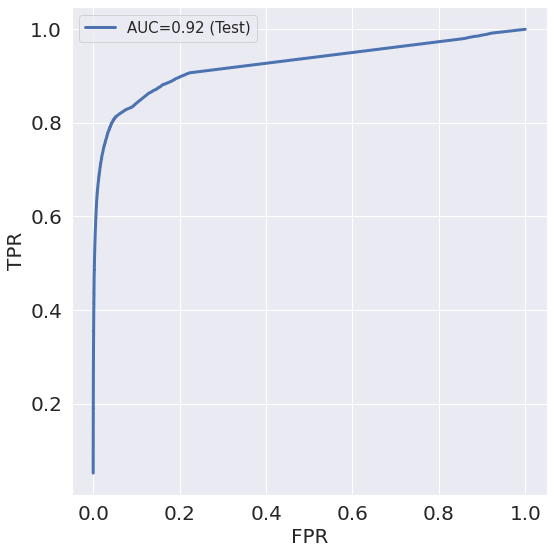

In [22]:
"""
Generate ROC figure
"""
fig3, ax3 = plt.subplots(1,1, figsize=(8,8))

plt.plot(FalsePositive_test, TruePositive_test, linewidth = 3, linestyle="-", label='AUC={0:.2f} (Test)'.format(auc_test))

ax3.tick_params(axis='x', labelsize=20)
ax3.tick_params(axis='y', labelsize=20)
plt.ylabel("TPR",fontsize=20)
plt.xlabel("FPR",fontsize=20)
plt.legend(ncol=1,fontsize=15) 
plt.tight_layout()

plt.show()

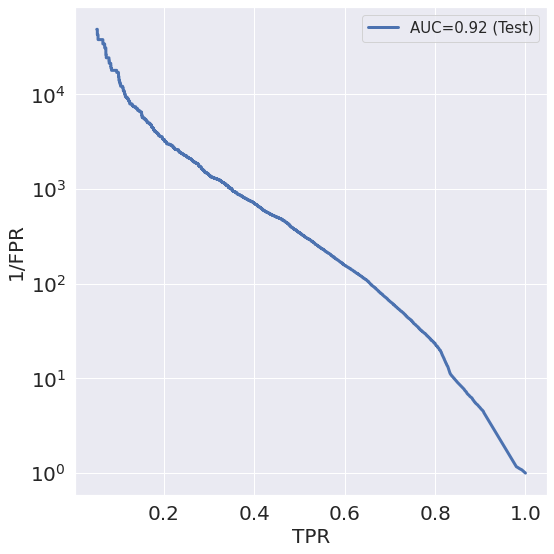

In [23]:
"""
Generate ROC figure
"""
fig4, ax4 = plt.subplots(1,1, figsize=(8,8))

plt.plot(TruePositive_test, 1/FalsePositive_test, linewidth = 3, linestyle="-", label='AUC={0:.2f} (Test)'.format(auc_test))

ax4.tick_params(axis='x', labelsize=20)
ax4.tick_params(axis='y', labelsize=20)
plt.yscale("log")
plt.ylabel("1/FPR",fontsize=20)
plt.xlabel("TPR",fontsize=20)
plt.legend(ncol=1,fontsize=15) 
plt.tight_layout()

plt.show()

No handles with labels found to put in legend.


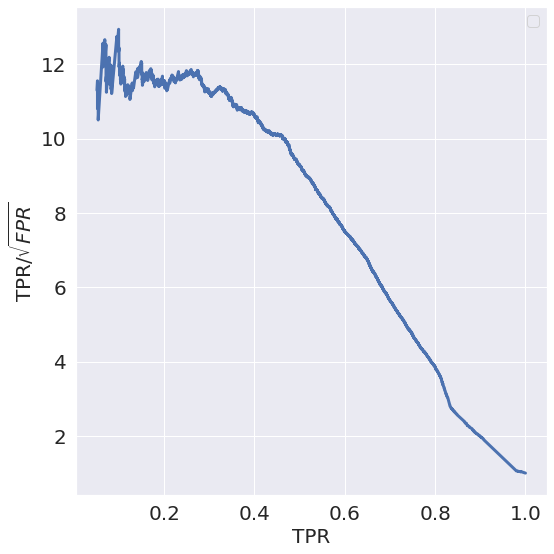

In [24]:
"""
Generate SIC figure
"""
fig5, ax5 = plt.subplots(1,1, figsize=(8,8))

plt.plot(TruePositive_test, TruePositive_test/np.sqrt(FalsePositive_test), linewidth = 3, linestyle="-")

ax5.tick_params(axis='x', labelsize=20)
ax5.tick_params(axis='y', labelsize=20)
plt.ylabel(r'TPR/$\sqrt{FPR}$',fontsize=20)
plt.xlabel("TPR",fontsize=20)
plt.legend(ncol=1,fontsize=15) 
plt.tight_layout()

plt.show()

Text(0.5, 1.0, 'DNN scores (test)')

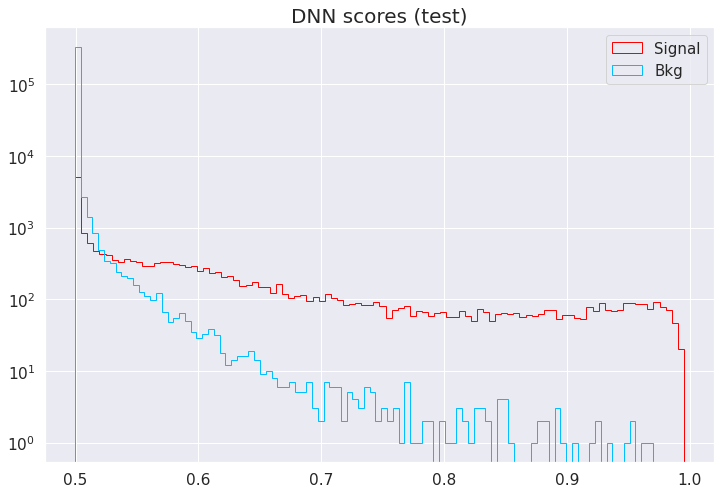

In [25]:
fig7, ax7 = plt.subplots(1,1,figsize=(12,8))

is_mc = np.where(y_mc_test == 1)
is_bkg = np.where(y_mc_test == 0)

plt.hist(predict_test[is_mc], bins=100, stacked=False, histtype='step', color="red", label='Signal', density=False)
plt.hist(predict_test[is_bkg], bins=100, stacked=False, histtype='step', color="deepskyblue", label='Bkg', density=False)

plt.yscale("log")
plt.legend(loc="upper right", fontsize=15)
plt.title('DNN scores (test)', fontsize=20)

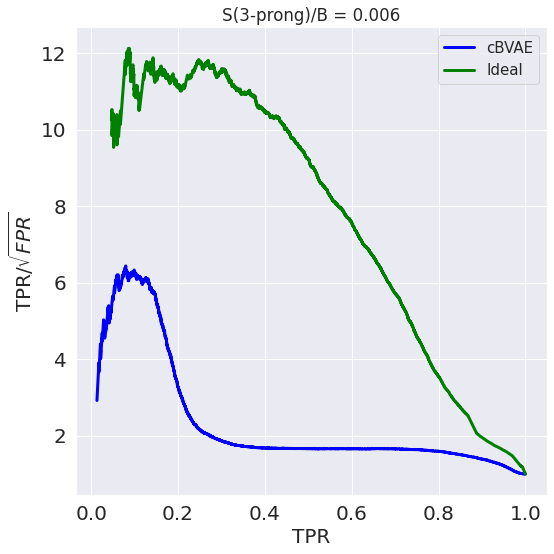

In [32]:
"""
Generate SIC figure comparison
"""
fig8, ax8 = plt.subplots(1,1, figsize=(8,8))

predict_2p_cbvae = np.load("/workdir/huichi/gan-sidebands/predictions/predict_test_cbvae_6var_3prong.npy")
predict_2p_ideal = np.load("/workdir/huichi/gan-sidebands/predictions/predict_test_ideal_6var_3prong.npy")

roc_2p_cbvae = roc_curve(y_mc_test, predict_2p_cbvae)
roc_2p_ideal = roc_curve(y_mc_test, predict_2p_ideal)

fpr_2p_cbvae, tpr_2p_cbvae = roc_2p_cbvae[0], roc_2p_cbvae[1]
fpr_2p_ideal, tpr_2p_ideal = roc_2p_ideal[0], roc_2p_ideal[1]

idx_2p_cbvae = np.where(fpr_2p_cbvae>1.8382353*1e-5)
idx_2p_ideal = np.where(fpr_2p_ideal>1.8382353*1e-5)

fpr_2p_cbvae, tpr_2p_cbvae = fpr_2p_cbvae[idx_2p_cbvae], tpr_2p_cbvae[idx_2p_cbvae]
fpr_2p_ideal, tpr_2p_ideal = fpr_2p_ideal[idx_2p_ideal], tpr_2p_ideal[idx_2p_ideal]

plt.plot(tpr_2p_cbvae, tpr_2p_cbvae/np.sqrt(fpr_2p_cbvae), linewidth = 3, linestyle="-", color="blue", label="cBVAE")
plt.plot(tpr_2p_ideal, tpr_2p_ideal/np.sqrt(fpr_2p_ideal), linewidth = 3, linestyle="-", color="green", label="Ideal")

ax8.tick_params(axis='x', labelsize=20)
ax8.tick_params(axis='y', labelsize=20)
plt.ylabel(r'TPR/$\sqrt{FPR}$',fontsize=20)
plt.xlabel("TPR",fontsize=20)
plt.legend(ncol=1,fontsize=15)
plt.title("S(3-prong)/B = 0.006")
plt.tight_layout()

plt.show()

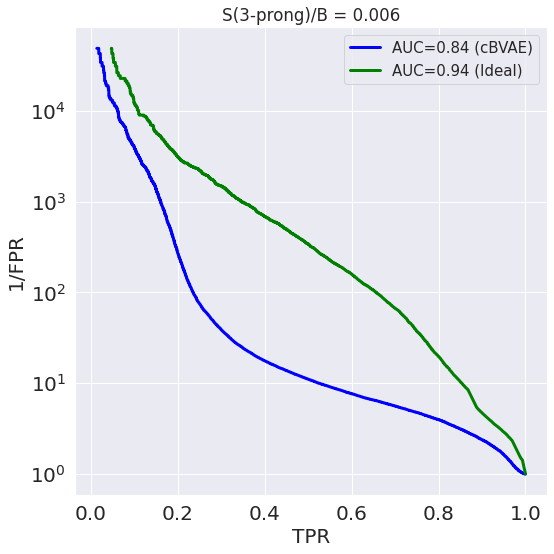

In [33]:
"""
Generate ROC figure comparison
"""
fig9, ax9 = plt.subplots(1,1, figsize=(8,8))

auc_2p_cbvae = roc_auc_score(y_mc_test, predict_2p_cbvae)
auc_2p_ideal = roc_auc_score(y_mc_test, predict_2p_ideal)

plt.plot(tpr_2p_cbvae, 1/fpr_2p_cbvae, linewidth = 3, linestyle="-", color="blue", label='AUC={0:.2f} (cBVAE)'.format(auc_2p_cbvae))
plt.plot(tpr_2p_ideal, 1/fpr_2p_ideal, linewidth = 3, linestyle="-", color="green", label='AUC={0:.2f} (Ideal)'.format(auc_2p_ideal))

ax9.tick_params(axis='x', labelsize=20)
ax9.tick_params(axis='y', labelsize=20)
plt.ylabel('1/FPR',fontsize=20)
plt.xlabel("TPR",fontsize=20)
plt.legend(ncol=1,fontsize=15)
plt.title("S(3-prong)/B = 0.006")
plt.yscale("log")
plt.tight_layout()

plt.show()